In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import math
from collections import OrderedDict
import h5py
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
# pip install matplotlib

In [3]:
config = {
  "max_segment_num": 20,
  "max_frame_num": 200,
  "similarity_dim": 1000,
  "concept_dim": 300,
  "in_channel": 2048,
  "conv1_channel": 512,
  "conv2_channel": 256,
  "deconv1_channel": 1024,
  "deconv2_channel": 1024,

  "gpu": "0",
  "num_workers": 0,
  "epoch": 10,
  "batch_size": 10,
  "lr": 1e-5,
  "train_videos": [1,2,3],
  "test_video": 4,
  "top_percent": 0.02
}

In [4]:
# Function to load the pickle file
def load_pickle(filename):
    with open(filename,'rb') as f:
        return pickle.load(f)

In [5]:
# Custom class to load the dataset
class UTEDataset(Dataset):
    def __init__(self, videos):
        self.dataset = []
        train_videos = videos
        for video_id in train_videos:
            for _, _, files in os.walk(f"../../data/Oracle_summaries/P0{video_id}"):
                for file in files:
                    self.dataset.append(file[:file.find("_oracle.txt")]+f"_{video_id}") # eg. Food_Hands_1 -> (q1_q2_video_id)
        self.embedding=load_pickle("../../data/query_dictionary.pkl")

    def list_dataset(self):
        return self.dataset
                
    def __getitem__(self, index):
        """
        This method will be callded when access indexed.
        """
        video_id = self.dataset[index].split("_")[2] # get video id from Food_Hands_1 1 here is video id
        f = h5py.File(f'../../data/processed/V{video_id}_resnet_avg.h5', 'r') # loading features
        features=torch.tensor(f["features"][()], dtype=torch.float32)
        seg_len=torch.tensor(f["seg_len"][()], dtype=torch.int32)
        

        query_1, query_2 = self.dataset[index].split("_")[0:2]
        
        query_1_GT = torch.zeros(20*200) # GT of shape 20*200 (max_seg_size*max_shot_size)
        query_2_GT = torch.zeros(20*200)

        transfer={"Cupglass":"Glass",
                  "Musicalinstrument":"Instrument",
                  "Petsanimal":"Animal"}

        with open(f"../../data/Dense_per_shot_tags/P0{video_id}/P0{video_id}.txt", "r") as f:
            lines = f.readlines()
            for index, line in enumerate(lines):
                queries = line.strip().split(',')
                if query_1 in queries:
                    query_1_GT[index] = 1
                if query_2 in queries:
                    query_2_GT[index] = 1
                # NO need of the condition given below 🟥
                # if index == 19:
                #     break

        shot_num = seg_len.sum() # getting total count of shots by summing individual segment length
        mask_GT = torch.zeros(20*200, dtype=torch.bool)
        for i in range(shot_num):
            mask_GT[i] = 1

        if query_1 in transfer:
            query_1=transfer[query_1]
        if query_2 in transfer:
            query_2=transfer[query_2]

        q1_text = query_1
        q2_text = query_2
        # print("Q1: ", query_1)
        # print("Q2: ", query_2)
        query_1 = torch.tensor(self.embedding[query_1], dtype=torch.float32)
        query_2 = torch.tensor(self.embedding[query_2], dtype=torch.float32)
        
        return features, seg_len, query_1, query_2, query_1_GT, query_2_GT, mask_GT, q1_text, q2_text

    def __len__(self):
        return len(self.dataset)

In [6]:
model = torch.jit.load('train2_test4.pt')

In [7]:
UTE_dataset=UTEDataset([1,2,3,4])
features, seg_len, q1, q2, q1gt, q2gt, mask_GT, q1t, q2t = UTE_dataset[0]
concept1_score,concept2_score, self_attention_wei, query_relevance_attention_wei, global_attention_wei=model(features.unsqueeze(0).to('cuda'),seg_len.unsqueeze(0).to('cuda'),q1.unsqueeze(0).to('cuda'),q2.unsqueeze(0).to('cuda'))


k shape : [20, 10, 256] | q shape: [20, 10, 256]
wei shape:  [20, 10, 10]
k shape : [20, 10, 256] | q shape: [20, 10, 256]
wei shape:  [20, 10, 10]
k shape : [10, 20, 256] | q shape: [10, 20, 256]
wei shape:  [10, 20, 20]
similar1:  [1, 4000, 300]
concept1_similar.unsqueeze(1):  [1, 1, 300]


In [8]:
UTE_dataset.list_dataset()

['Book_Street_1',
 'Book_Sun_1',
 'Book_Tree_1',
 'Building_Petsanimal_1',
 'Car_Petsanimal_1',
 'Chair_Desk_1',
 'Chair_Men_1',
 'Computer_Boat_1',
 'Cupglass_Garden_1',
 'Desk_Face_1',
 'Desk_Hands_1',
 'Desk_Office_1',
 'Drink_Face_1',
 'Drink_Food_1',
 'Drink_Musicalinstrument_1',
 'Face_Party_1',
 'Face_Phone_1',
 'Food_Grass_1',
 'Food_Hands_1',
 'Food_Men_1',
 'Food_Sky_1',
 'Grass_Hall_1',
 'Grass_Kids_1',
 'Grass_Phone_1',
 'Grass_Shoes_1',
 'Grass_Student_1',
 'Hall_Garden_1',
 'Hands_Men_1',
 'Hat_Phone_1',
 'Lady_Boat_1',
 'Market_Beach_1',
 'Men_Room_1',
 'Office_Chocolate_1',
 'Party_Tree_1',
 'Phone_Sun_1',
 'Room_Garden_1',
 'School_Ocean_1',
 'Shoes_Bed_1',
 'Sign_Musicalinstrument_1',
 'Sky_Street_1',
 'Sky_Student_1',
 'Sky_Tree_1',
 'Street_Student_1',
 'Sun_Lake_1',
 'Window_Petsanimal_1',
 'Blonde_Book_2',
 'Book_Garden_2',
 'Book_Park_2',
 'Building_Boat_2',
 'Building_Food_2',
 'Car_School_2',
 'Chair_Hall_2',
 'Chair_Men_2',
 'Computer_Kids_2',
 'Computer_Park_

In [9]:
# pip install seaborn

In [18]:
%matplotlib inline

In [19]:

import seaborn as sns
def visualize_attention(attention_matrix):
    plt.figure(figsize=(40, 40))
    sns.heatmap(attention_matrix, cmap='YlGnBu', annot=True, fmt=".2f")
    plt.xlabel('Output Sequence')
    plt.ylabel('Input Sequence')
    plt.title('Attention Heatmap')
    plt.show()

# Assuming attention_matrix is your attention result, a 2D matrix
# visualize_attention(ip[0:20, : 50])

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def compare_summary(query, video_id, machine_summary):
    """
    ### Parameters
    query: eg. Foods_Hands_oracle.txt same as file name
    """
    query1, query2 = query.strip().split("_")[:2] # TODO: convert Animal to petsanimal
    gt_summary = []
    with open(f"../../data/Oracle_summaries/P0{video_id}/{query}", "r") as f:
        for line in f.readlines():
            gt_summary.append(int(line.strip()))

    gt_y = [3 for i in range(len(gt_summary))]
    m_y = [2 for i in range(len(machine_summary))]
    agt_summary = [] # Both query gt combined
    agt_summary_query1 = [] # Both query gt combined
    agt_summary_query2 = [] # Both query gt combined
    
    with open(f"../../data/Dense_per_shot_tags/P0{video_id}/P0{video_id}.txt", "r") as f:
        lines = f.readlines()
        for index, line in enumerate(lines):
            queries = line.strip().split(",")
            if query1 in queries or query2 in queries:
                agt_summary.append(index+1)
            if query1 in queries:
                agt_summary_query1.append(index+1)
            if query2 in queries:
                agt_summary_query2.append(index+1)
    print(f"both query gt size: {len(agt_summary)}")
    print(f"{query1} query gt size: {len(agt_summary_query1)}")
    print(f"{query2} query gt size: {len(agt_summary_query2)}")
    agt_y = [3.5 for i in range(len(agt_summary))]
    
    agt_query1_y = [3 for i in range(len(agt_summary_query1))]
    
    agt_query2_y = [2.5 for i in range(len(agt_summary_query2))]
    
    plt.figure(figsize=(20, 2)) # wide, tall
    plt.scatter(agt_summary, agt_y, color="green" , label="both ground truth", marker='|', s=300)
    plt.scatter(agt_summary_query1, agt_query1_y, color="purple", label=f"q1 ground truth: {query1}", marker='|', s=300)
    plt.scatter(agt_summary_query2, agt_query2_y, color="blue", label=f"q2 ground truth: {query2}", marker='|', s=300)
    plt.scatter(machine_summary.to('cpu'), m_y, color="red", label="Machine Summary", marker='|', s=300)
    plt.legend()
    plt.title(f'Ground Truth vs Machine Summary Analysis Graph for Query {query1} & {query2}')
    plt.xlabel('Temporal Sequence of Shots in Long Video')
    plt.ylabel('Summary Type')
    plt.savefig('compare_summary.png', bbox_inches='tight')

In [49]:
import torch
import matplotlib.pyplot as plt 

def get_total_query_focused_shots(small_top_index, small_score_shots, q1t, q2t, video_id):
    with open(f"../../data/Dense_per_shot_tags/P0{video_id}/P0{video_id}.txt", "r") as f:
        lines = f.readlines()
        s_a4_q1_shots = []
        s_a4_q1_score = []
        s_a4_q2_shots = []
        s_a4_q2_score = []
        for i in range(len(small_score_shots)):
            # print(lines[above_p4_shots[i]-1])
            # print("index: ", small_top_index[i]-1)
            queries = lines[small_top_index[i]-1].strip().split(',')
            if q1t in queries:
                s_a4_q1_shots.append(small_top_index[i])
                s_a4_q1_score.append(small_score_shots[i])
            if q2t in queries:
                s_a4_q2_shots.append(small_top_index[i])
                s_a4_q2_score.append(small_score_shots[i])
    return len(s_a4_q1_shots), len(s_a4_q2_shots)


def draw_shot_score_compare_graph_with_avg(model, dataset, video_id=1, query_no=0):
    """
    query_number: accepts 0-144, default is 0
    video_id: 1-3, default is 1
    """
    
    # here index number is query no from total of 145 if 3 videos are in training. 45 query in each video. so manage video 
    # if query is in range 0 - 44 then its video 1 and so on.
    features, seg_len, q1, q2, q1gt, q2gt, mask_GT, q1t, q2t = dataset[query_no]

    print("**** Given Query ****")
    print(f"Query 1: {q1t} \n Query 2: {q2t} \n Video id: {video_id} " )
    
    q1_pred_score, q2_pred_score, self_attention_wei, query_relevance_attention_wei, global_attention_wei = model(
                                                        features.unsqueeze(0).to('cuda'),
                                                        seg_len.unsqueeze(0).to('cuda'),
                                                            q1.unsqueeze(0).to('cuda'),
                                                            q2.unsqueeze(0).to('cuda')
                                                        )
    
    mask=torch.zeros(1,20,200,dtype=torch.bool).to('cuda') # (B, Seg_len, Shots) -> (1, 20, 200) shots: are also called `T` represents time is a single shot 
    for i in range(1):
        for j in range(len(seg_len.unsqueeze(0)[i])): # (B, seg_len) --> (1,20) 
            for k in range(seg_len.unsqueeze(0)[i][j]): # [0, 0] -> 120 meanig this loop will make 1 to all looped position 120 and rest will remain 0
                mask[i][j][k]=1
    
    score=(q1_pred_score+q2_pred_score)/2
    
    score=score.masked_select(mask)
    
    score_shots ,top_index=score.topk(int(score.shape[0]*1))
    small_score_shots ,small_top_index=score.topk(int(score.shape[0]*0.02))
    
    top_index+=1
    
    compare_summary(f"{q1t}_{q2t}_oracle.txt", video_id, small_top_index)
    print("Selected Shots: ", small_top_index+1)
    
    # total selected query focused shots in the summary in 2%
    q1_selected_shots, q2_selected_shots = get_total_query_focused_shots(small_top_index, small_score_shots, q1t, q2t, video_id)
    print(f"Total no of shots in summary: {len(small_top_index)}")
    print(f"No of shots selected in summary for query1: {q1_selected_shots}")
    print(f"No of shots selected in summary for query2: {q2_selected_shots}")

    above_point4 = [i for i in score_shots.to('cpu').detach().numpy() if i > 0.05]
    print("Above 0.4 total shots: ", len(above_point4))
    above_p4_shots = [int(top_index[i]) for i in range(len(score_shots.to('cpu').detach().numpy())) if score_shots[i] > 0.05]
    below_point4 = [i for i in score_shots.to('cpu').detach().numpy() if i < 0.05]
    
    with open(f"../../data/Dense_per_shot_tags/P0{video_id}/P0{video_id}.txt", "r") as f:
        lines = f.readlines()
        a4_q1_shots = []
        a4_q1_score = []
        a4_q2_shots = []
        a4_q2_score = []
        for i in range(len(above_point4)):
            # print(lines[above_p4_shots[i]-1])
            # print("i: ", i)
            # print("above_p4_shots[i]-1", above_p4_shots[i]-1)
            if above_p4_shots[i]-1 == 3588 and video_id == 4:
                continue
            queries = lines[above_p4_shots[i]-1].strip().split(',')
            if q1t in queries:
                a4_q1_shots.append(above_p4_shots[i])
                a4_q1_score.append(above_point4[i])
            if q2t in queries:
                a4_q2_shots.append(above_p4_shots[i])
                a4_q2_score.append(above_point4[i])
        
    plt.figure(figsize=(20, 2))
    plt.scatter(top_index.to('cpu').detach().numpy(), score_shots.to('cpu').detach().numpy(), label=f"other", marker='|', s=2, color="c")
    plt.scatter(a4_q1_shots, a4_q1_score, marker='x', color="purple", label=f"Query 1: {q1t}", s=2)
    plt.scatter(a4_q2_shots, a4_q2_score, marker='^', color='blue', label=f"Query 2: {q2t}", s=2)
    plt.ylabel("Predicted Score")
    plt.xlabel("Temporal Sequence of Shots in Long Video")
    plt.title("Query-Shot Relevance Score Analysis Graph")
    plt.legend()
    plt.savefig('score.png', bbox_inches='tight')
    

## Vid 1

**** Given Query ****
Query 1: Book 
 Query 2: Street 
 Video id: 1 
k shape : [20, 10, 256] | q shape: [20, 10, 256]
wei shape:  [20, 10, 10]
k shape : [20, 10, 256] | q shape: [20, 10, 256]
wei shape:  [20, 10, 10]
k shape : [10, 20, 256] | q shape: [10, 20, 256]
wei shape:  [10, 20, 20]
similar1:  [1, 4000, 300]
concept1_similar.unsqueeze(1):  [1, 1, 300]
both query gt size: 400
Book query gt size: 201
Street query gt size: 199
Selected Shots:  tensor([2576,  667,  614, 2488, 1014, 2568,   11, 1535, 2582, 1895,  697, 1024,
         856, 1881,   21,  573, 1545, 2570,  309, 2565, 2278,  673, 2571, 1372,
        2572, 1905,  707,  659, 2580,  866, 2599, 1021, 2567, 1019, 2288, 2577,
          16,  319,  260, 2541, 1540, 2554, 1542, 1382,   18, 2609, 1836, 1900,
        2564, 2573,  702, 2285, 1902,  861,  485], device='cuda:0')
Total no of shots in summary: 55
No of shots selected in summary for query1: 5
No of shots selected in summary for query2: 4
Above 0.4 total shots:  2783


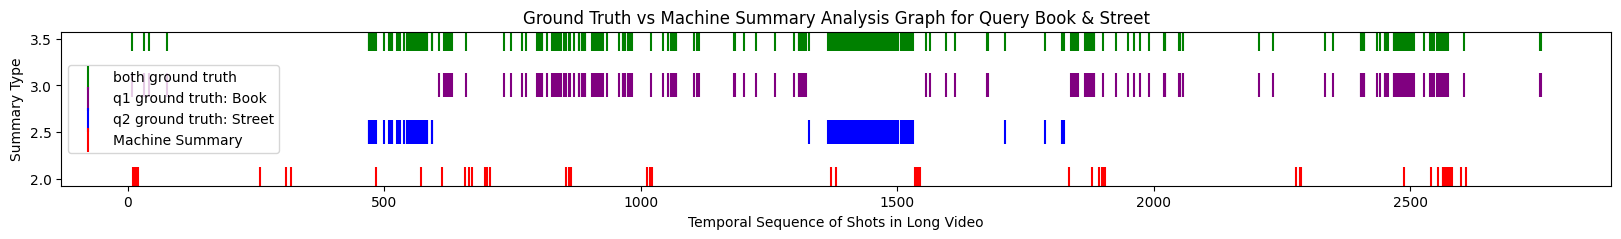

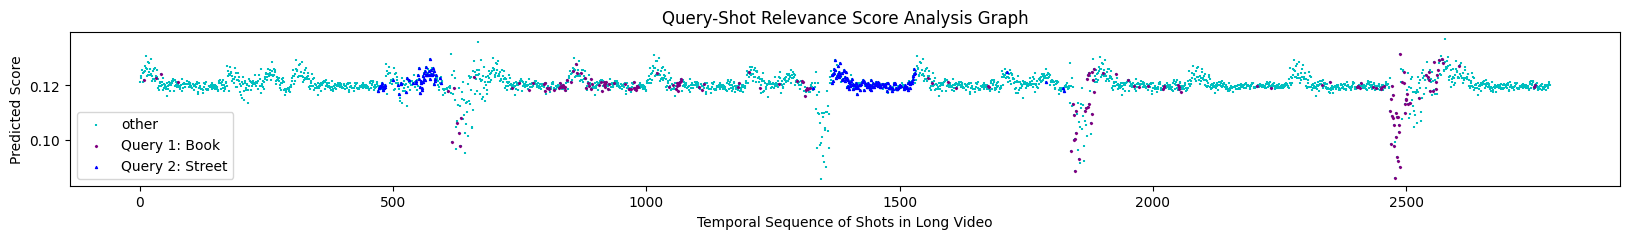

In [52]:
# model.to('cuda')
draw_shot_score_compare_graph_with_avg(model, UTE_dataset, 1, 0)

**** Given Query ****
Query 1: Food 
 Query 2: Sky 
 Video id: 1 
k shape : [20, 10, 256] | q shape: [20, 10, 256]
wei shape:  [20, 10, 10]
k shape : [20, 10, 256] | q shape: [20, 10, 256]
wei shape:  [20, 10, 10]
k shape : [10, 20, 256] | q shape: [10, 20, 256]
wei shape:  [10, 20, 20]
similar1:  [1, 4000, 300]
concept1_similar.unsqueeze(1):  [1, 1, 300]
both query gt size: 1087
Food query gt size: 895
Sky query gt size: 192
Selected Shots:  tensor([2576,  667,  614, 2488, 1014, 2568,   11, 1535, 2582, 1895,  697, 1024,
         856, 1881,   21,  573, 1545, 2570,  309, 2565, 2278,  673, 2571, 1372,
        2572, 1905,  707,  659, 2580,  866, 2599, 1021, 2567, 1019, 2288, 2577,
          16,  319,  260, 2541, 1540, 2554, 1382, 1542,   18, 2609, 1836, 1900,
        2564, 2573,  702, 2285, 1902,  861,  485], device='cuda:0')
Total no of shots in summary: 55
No of shots selected in summary for query1: 22
No of shots selected in summary for query2: 3
Above 0.4 total shots:  2783


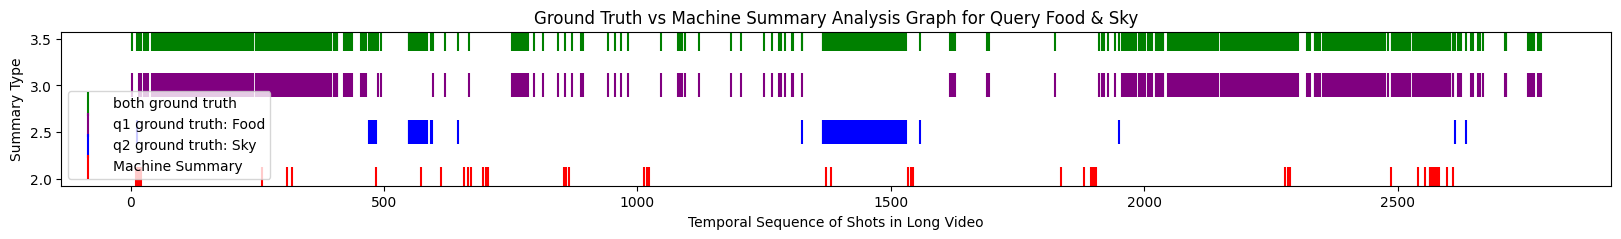

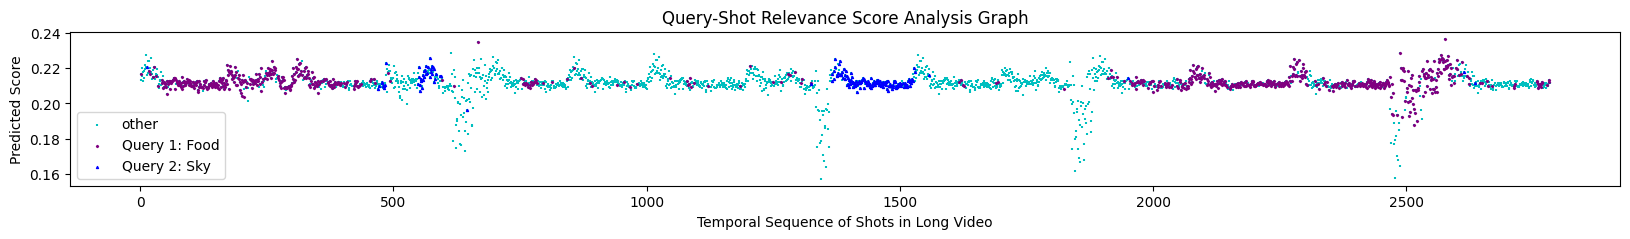

In [53]:
draw_shot_score_compare_graph_with_avg(model, UTE_dataset, 1, 20)

**** Given Query ****
Query 1: Market 
 Query 2: Beach 
 Video id: 1 
k shape : [20, 10, 256] | q shape: [20, 10, 256]
wei shape:  [20, 10, 10]
k shape : [20, 10, 256] | q shape: [20, 10, 256]
wei shape:  [20, 10, 10]
k shape : [10, 20, 256] | q shape: [10, 20, 256]
wei shape:  [10, 20, 20]
similar1:  [1, 4000, 300]
concept1_similar.unsqueeze(1):  [1, 1, 300]
both query gt size: 313
Market query gt size: 311
Beach query gt size: 2
Selected Shots:  tensor([2576,  667,  614, 2488, 1014, 2568,   11, 1535, 2582, 1895,  697, 1024,
         856, 1881,   21,  573, 1545, 2570,  309, 2565, 2278,  673, 2571, 1372,
        2572, 1905,  707,  659, 2580,  866, 2599, 1021, 2567, 1019, 2288, 2577,
          16,  319,  260, 2541, 1540, 2554, 1382, 1542,   18, 2609, 1836, 1900,
        2564, 2573,  702, 2285, 1902,  861,  485], device='cuda:0')
Total no of shots in summary: 55
No of shots selected in summary for query1: 6
No of shots selected in summary for query2: 0
Above 0.4 total shots:  2783


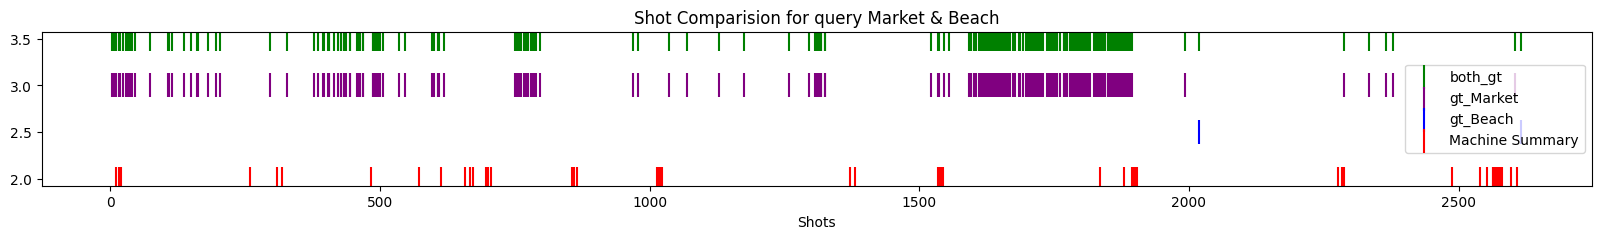

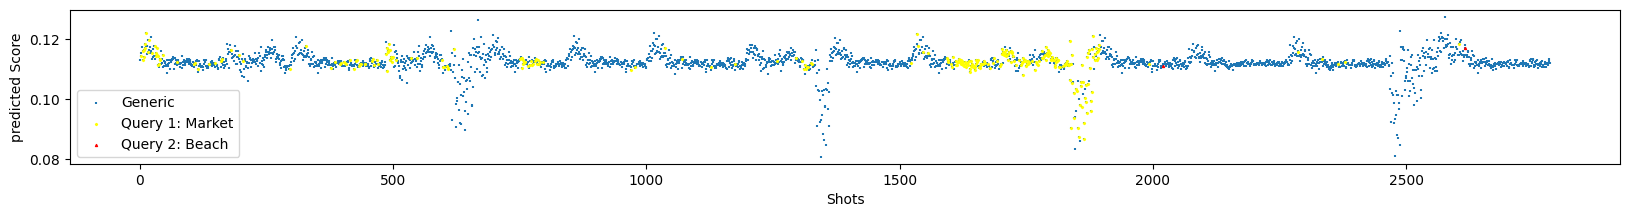

In [26]:
draw_shot_score_compare_graph_with_avg(model, UTE_dataset, 1, 30)

## Vid 2